## Iniciando no Pytorch

In [ ]:
import torch
import torch.nn as nn

#Modelo que realiza o plot de uma função linear
class SimpleModel(nn.Module):
    def __init__(self): # construtor onde você define as camadas da rede.
        super().__init__()
        # Definição da camadas
        self.layers = nn.Linear(1, 1) # Um neurônio e uma classe # Outra camada linear | hidden_size, num_classes

    def forward(self, x): # método que define como os dados percorrem a rede.
        # Definição do encaminhamento dos dados
        out = self.layers(x) # Os dados passam pela função Linear
        return out

### Como treinar esse redinha?

Utilizaremos as ferramentas da dataset do pytorch para isso.

In [ ]:
import torch.distributions.uniform as urand # usar números aleatórios
from torch.utils.data import DataLoader, Dataset

class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples): #Construtor, (self, função linar,intervalo, quantidade de amostras)
      X = urand.Uniform(interval[0], interval[1]).sample((nsamples,))
      self.data = [[{x, }] for x in X]
      pass
  def __len__(self): # Tamanho do dataset
      return len(self.data)

  def __getitem__(self, idx): # Retorna um item do dataset
      return self.data[idx]

In [ ]:
# Parâmetros do dataset
line = lambda x: 2*x + 3
interval = [-10, 10]
train_nsamples = 1000
test_nsamples = 100

# Treinando os dois modelos
train_data = AlgebraicDataset(line, interval, train_nsamples)
test_data = AlgebraicDataset(line, interval, test_nsamples)

#construo o dataset passando os dados de acordo com o batch_size (no caso, todos os dados)
train_dataloader = DataLoader(train_data, batch_size=train_nsamples, shuffle=True) # Shuffle é baiscamente embaralhar os dados
test_dataloader = DataLoader(test_data, batch_size=test_nsamples, shuffle=False)

## Construindo uma rede MLP
Pegando como exemplo uma MLP de 3 camadas semelhantes a analisada na atividade prática sobre backpropagation, podemos montar a rede neural da seguinte forma já adaptando para um problema com imagens:
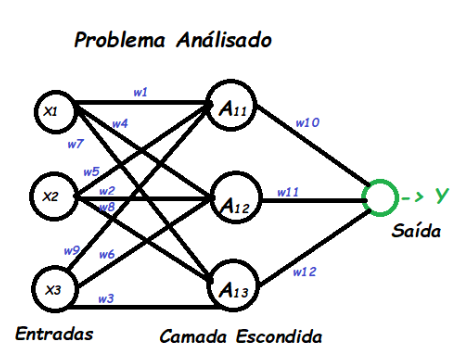

In [ ]:
from torch import nn
import torch

class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__() # Inicializando o modelo

        self.flatten = nn. Flatten()

        self.layers = nn.Sequential( # 3 camada intermediárias
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        v = self.flatten(x)
        return self.layers(v)

In [ ]:
# Selecionando a GPU para um processamento mais rápido e dedicado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = MLPClassifier().to(device)

cuda


## Entendendo o Tipo de Rede Neural Utilizado no Problema (Redes Neurais Convolucionais)
A escolha de uma rede neural convolucional (CNN) para problemas com imagens é natural, visto que este tipo de rede é especialmente projetado para lidar com a variabilidade espacial das imagens. As CNNs são capazes de capturar padrões locais, como bordas, texturas e formas, que são fundamentais para a interpretação visual.

## Estrutura da Rede Neural Convolucional Genérica em PyTorch
A estrutura em PyTorch para CNNs é composta por várias camadas convolucionais, seguidas de camadas de ativação e de pooling, que ajudam a reduzir a dimensionalidade e a capturar características cada vez mais abstratas da imagem. Em seguida, há camadas totalmente conectadas (fully connected) que realizam a classificação final com base nas características extraídas pelas camadas convolucionais.

O número crescente de filtros (64, 128, 256, 512) permite que a rede capture padrões cada vez mais complexos e abstratos à medida que a profundidade da rede aumenta.

In [ ]:
# Definição do modelo CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 14 * 14)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instanciar o modelo
model = SimpleCNN(num_classes=29)

## Arquitetura da rede do trabalho
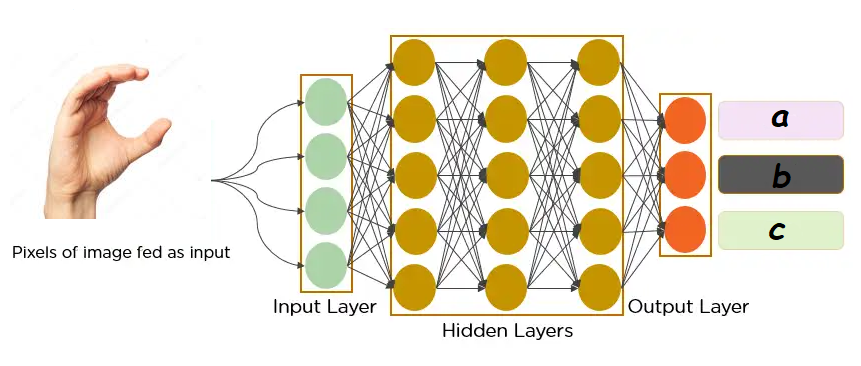

O objetivo deste trabalho é analisar técnicas para contornar o overfitting de modelos utilizados em Vision-based Continuous Sign Language Recognition
(CSLR).

A estratégia implementada é inspirada no paper: [Visual Alignment Constraint for Continuous Sign Language Recognition](https://openaccess.thecvf.com/content/ICCV2021/papers/Min_Visual_Alignment_Constraint_for_Continuous_Sign_Language_Recognition_ICCV_2021_paper.pdf)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. Dividir o Dataset em Dados de Treino e Teste
Primeiro, vamos dividir o DataFrame em dados de treino e teste usando a função train_test_split do scikit-learn.

In [ ]:
# Carregar os datasets
df1 = pd.read_parquet("hf://datasets/Marxulia/asl_sign_languages_alphabets_v03/data/train-00000-of-00001.parquet")
df2 = pd.read_parquet("hf://datasets/Marxulia/asl_sign_languages_alphabets_v02/data/train-00000-of-00001.parquet")

# Dividir em treino (70%) e teste (30%)
train_df1, test_df1 = train_test_split(df1, test_size=0.3, random_state=42)
train_df2, test_df2 = train_test_split(df2, test_size=0.3, random_state=42)

# Concatenar os DataFrames
train_df = pd.concat([train_df1, train_df2])
test_df = pd.concat([test_df1, test_df2])

# Dicionário de mapeamento de classes para letras
class_to_letter = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S',
    19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'space', 27: 'delete', 28: 'nothing'
}
print(f"Train size dataset 1: {len(train_df1)}, Test size: {len(test_df1)}")
print(f"Train size dataset 2: {len(train_df2)}, Test size: {len(test_df2)}")
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size dataset 1: 7611, Test size: 3262
Train size dataset 2: 364, Test size: 156
Train size: 7975, Test size: 3418


## 2. Treinar o Modelo e Visualizar o Erro Percentual Médio
Vamos ajustar a classe ASLDataset para usar DataFrames diferentes para treino e teste. Depois, treinamos o modelo e plotamos o erro percentual médio em cada época.

In [ ]:
# Dataset personalizado para ASL
class ASLDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_bytes = self.dataframe.iloc[idx]['image']['bytes']  # Access 'bytes' instead of 'image_bytes'
        image = Image.open(io.BytesIO(image_bytes))
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformações dos dados
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Instanciar os datasets e dataloaders
train_dataset = ASLDataset(train_df, transform=transform)
test_dataset = ASLDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo ResNet18
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 29)  # Ajustar para o número de classes ASL (29)

# Mover modelo para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento com plotagem
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted_train = torch.max(outputs, 1) # Calculate predictions for training
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item() # Update correct count for training

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train # Calculate training accuracy
        train_accuracies.append(train_accuracy) # Store training accuracy
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}') # Print training accuracy

        # Avaliar no conjunto de teste
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Plotar o erro percentual médio
    plt.figure()
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    plt.show()

    plt.figure()
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/4, Train Loss: 1.7276, Train Accuracy: 0.4648
Test Loss: 1.3495, Accuracy: 0.5641
Epoch 1/4, Train Loss: 0.7297, Train Accuracy: 0.7635
Test Loss: 0.9391, Accuracy: 0.6875
Epoch 2/4, Train Loss: 0.3970, Train Accuracy: 0.8665
Test Loss: 1.0216, Accuracy: 0.7106
Epoch 3/4, Train Loss: 0.3007, Train Accuracy: 0.9021
Test Loss: 0.5149, Accuracy: 0.8397
Epoch 4/4, Train Loss: 0.1555, Train Accuracy: 0.9518
Test Loss: 0.5961, Accuracy: 0.8180


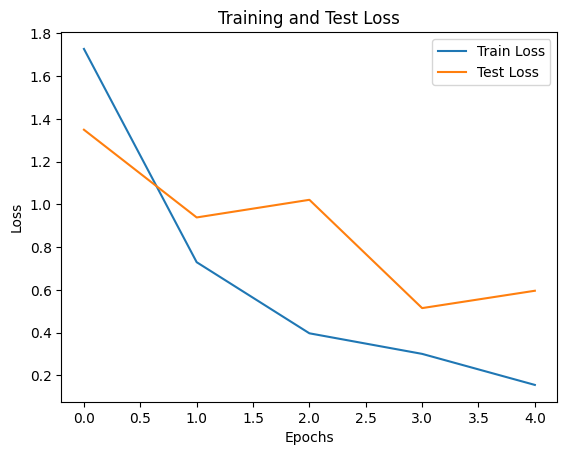

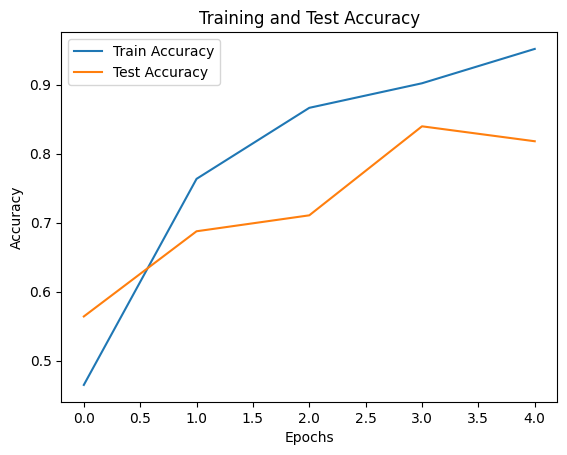

In [ ]:
# Treinar o modelo
train_model(model, train_loader, test_loader, criterion, optimizer)

## 3. Realizar a Classificação de uma Imagem de Entrada
Para classificar uma imagem de entrada, definimos uma função que recebe a imagem, aplica as transformações necessárias e usa o modelo treinado para fazer a predição.

In [ ]:
def classify_image(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item(), class_to_letter[predicted.item()]

# Exemplo de uso
image_path = './sample_data/c.jpeg'  # Substitua pelo caminho da sua imagem
predicted_class, predicted_letter = classify_image(model, image_path, transform)
print(f'Predicted class: {predicted_class}')
print(f'Predicted letter: {predicted_letter}')


Predicted class: 2
Predicted letter: C


## 4 - VAC | Restrição de Alinhamento Visual

Para resolver o treinamento insuficiente do extrator de recursos, o VAC (Visual Alignment Constraint) proposto aprimora a capacidade de generalização do extrator visual restringindo o espaço de recursos com a supervisão do alinhamento. Essa técnica visa minimizar a diferença entre as representações de características visuais de sinais contínuos similares, resultando em uma melhor generalização do modelo.

In [ ]:
# Função de perda com VAC
def visual_alignment_constraint(outputs):
    # Implementação da função de restrição de alinhamento visual
    vac_loss = torch.mean(outputs ** 2)  # Example: Mean squared value of outputs
    return vac_loss

# Função de treinamento com VAC
def train_model_with_vac(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, vac_weight=0.1):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            vac_loss = visual_alignment_constraint(outputs)
            total_loss = loss + vac_weight * vac_loss
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

        # Avaliar no conjunto de teste
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                vac_loss = visual_alignment_constraint(outputs)
                total_loss = loss + vac_weight * vac_loss
                test_loss += total_loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Plotar o erro percentual médio
    plt.figure()
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    plt.show()

    plt.figure()
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy')
    plt.show()

Epoch 0/4, Train Loss: 0.5643, Train Accuracy: 0.9767
Test Loss: 0.4540, Test Accuracy: 0.9567
Epoch 1/4, Train Loss: 0.2735, Train Accuracy: 0.9994
Test Loss: 0.4315, Test Accuracy: 0.9500
Epoch 2/4, Train Loss: 0.2401, Train Accuracy: 0.9997
Test Loss: 0.3664, Test Accuracy: 0.9687
Epoch 3/4, Train Loss: 0.2260, Train Accuracy: 0.9999
Test Loss: 0.3614, Test Accuracy: 0.9699
Epoch 4/4, Train Loss: 0.2186, Train Accuracy: 1.0000
Test Loss: 0.3571, Test Accuracy: 0.9693


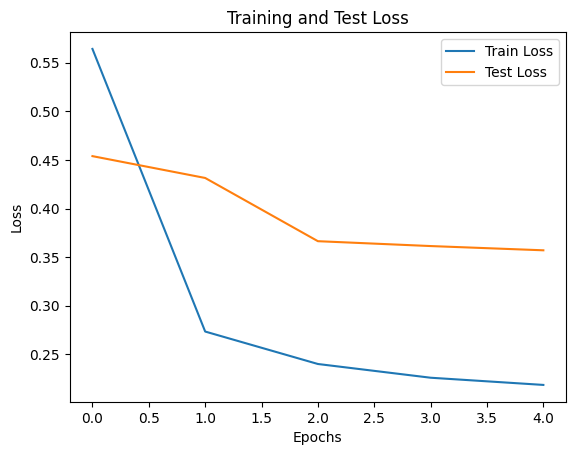

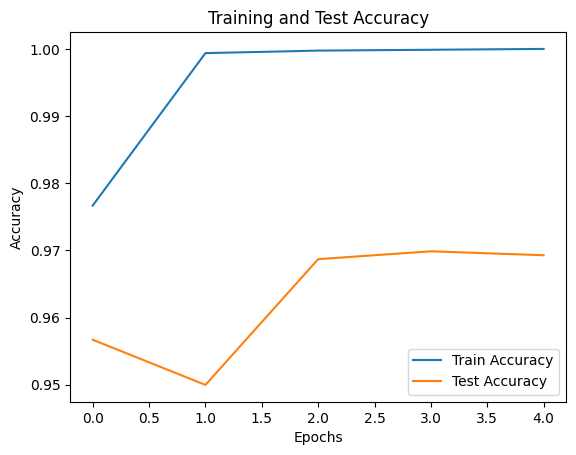

In [ ]:
# Treinar o modelo com VAC
train_model_with_vac(model, train_loader, test_loader, criterion, optimizer)